In [1]:
%run ./Binance_keys.ipynb
%run ./MRcoins.ipynb
from binance import Client
import pandas as pd
import matplotlib.pyplot as plt
client = Client(api_key, secret_key)

In [2]:
posframe = pd.read_csv('positioncheck')

In [3]:
def getHLCdata(symbol, minute='15m', hours='168'):
    frame = pd.DataFrame(client.get_historical_klines(symbol, minute, hours + ' hours ago UTC'))
    frame = frame[[0,2,3,4]]
    frame.columns = ['time','high', 'low', 'close']
    frame
    return frame

In [4]:
btc = getHLCdata('BTCUSDT')
btc

,time,high,low,close
0,1646352000000,42527.30000000,42247.38000000,42283.57000000
1,1646352900000,42300.69000000,42117.11000000,42197.34000000
2,1646353800000,42371.22000000,42105.80000000,42129.54000000
3,1646354700000,42152.27000000,41509.94000000,41603.36000000
4,1646355600000,41683.42000000,41069.91000000,41310.77000000
...,...,...,...,...
667,1646952300000,39487.36000000,39374.94000000,39442.06000000
668,1646953200000,39534.80000000,39413.86000000,39477.11000000
669,1646954100000,39568.99000000,39366.37000000,39545.00000000
670,1646955000000,39595.68000000,39415.14000000,39423.59000000


In [5]:
def applyBBSMA(df, bandperiod=20, bandsigma=2, maperiod=50):
    df['high'] = pd.to_numeric(df['high'], downcast = 'float', errors='coerce')
    df['low'] = pd.to_numeric(df['low'], downcast = 'float', errors='coerce')
    df['close'] = pd.to_numeric(df['close'], downcast = 'float', errors='coerce')
    df['typicalPrice'] = (df['high'] + df['low'] + df['close'])/3
    df['SMA'] = df.typicalPrice.rolling(maperiod).mean()
    df['basis'] = df.typicalPrice.rolling(bandperiod).mean()
    df['upBand'] = df.typicalPrice.rolling(bandperiod).mean() + bandsigma*df.close.rolling(bandperiod).std()
    df['downBand'] = df.typicalPrice.rolling(bandperiod).mean() - bandsigma*df.close.rolling(bandperiod).std()
    df

In [6]:
def plotBBSMA(symbol = 'BTCUSDT', minute = '15m', hours='168', bandperiod=20, bandsigma=2, maperiod=50):
    symboldata = getHLCdata(symbol, minute, hours)
    applyBBSMA(symboldata, bandperiod, bandsigma, maperiod)
    symboldataclean = symboldata.dropna()
    df = symboldataclean
    plt.figure(figsize=(12,5))
    plt.plot(df['time'], df['close'])
    plt.plot(df['time'], df['SMA'])
    plt.plot(df['time'], df['basis'])
    plt.fill_between(df['time'], df['upBand'], df['downBand'], alpha = 0.1)
    plt.title(f'{symbol} close data on {minute} minute timeframe for {hours} hours with {bandperiod}, {bandsigma} bollinger bands and {maperiod} moving average')
    plt.xlabel('time')
    plt.ylabel('close')

In [7]:
def plotSMA(symbol = 'BTCUSDT', minute = '15m', hours='168', bandperiod=20, bandsigma=2, maperiod=50):
    symboldata = getHLCdata(symbol, minute, hours)
    applyBBSMA(symboldata, bandperiod, bandsigma, maperiod)
    symboldataclean = symboldata.dropna()
    df = symboldataclean
    plt.figure(figsize=(12,5))
    plt.plot(df['time'], df['close'])
    plt.plot(df['time'], df['SMA'])
    plt.title(f'{symbol} close data on {minute} minute timeframe for {hours} hours with {maperiod} moving average')
    plt.xlabel('time')
    plt.ylabel('close')

In [8]:
def plotBB(symbol = 'BTCUSDT', minute = '15m', hours='168', bandperiod=20, bandsigma=2, maperiod=50):
    symboldata = getHLCdata(symbol, minute, hours)
    applyBBSMA(symboldata, bandperiod, bandsigma, maperiod)
    symboldataclean = symboldata.dropna()
    df = symboldataclean
    plt.figure(figsize=(12,5))
    plt.plot(df['time'], df['close'])
    plt.plot(df['time'], df['basis'])
    plt.fill_between(df['time'], df['upBand'], df['downBand'], alpha = 0.1)
    plt.title(f'{symbol} close data on {minute} minute timeframe for {hours} hours with {bandperiod}, {bandsigma} bollinger bands')
    plt.xlabel('time')
    plt.ylabel('close')

In [9]:
def plotRawPrice(symbol = 'BTCUSDT', minute = '15m', hours='168'):
    symboldata = getHLCdata(symbol, minute, hours)
    applyBBSMA(symboldata)
    symboldataclean = symboldata.dropna()
    df = symboldataclean
    plt.figure(figsize=(12,5))
    plt.plot(df['time'], df['close'])
    plt.title(f'{symbol} close data on {minute} minute timeframe for {hours} hours')
    plt.xlabel('time')
    plt.ylabel('close')

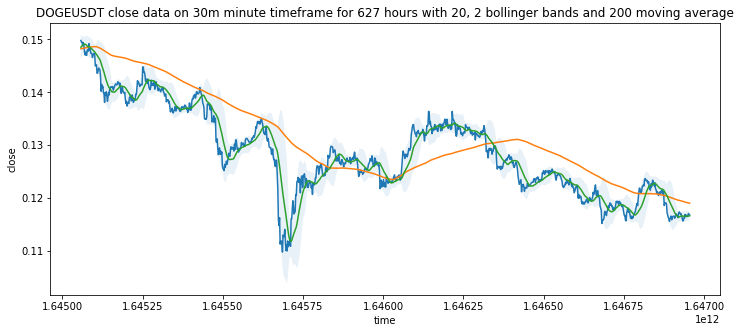

In [10]:
plotBBSMA(symbol='DOGEUSDT', minute='30m', hours='627',maperiod=200)

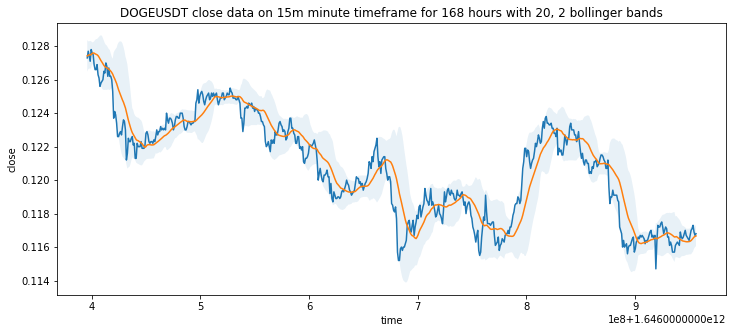

In [11]:
plotBB('DOGEUSDT')

In [12]:
def changepos(coin, order, buy=True):
    if buy:
        posframe.loc[posframe.currency == coin, 'position'] = posframe.loc[posframe.currency == coin, 'position'] + 1
        posframe.loc[posframe.currency == coin, 'quantity'] = posframe.loc[posframe.currency == coin, 'position'] + float(order['executedqty'])
    if sell:
        posframe.loc[posframe.currency == coin, 'position'] = posframe.loc[posframe.currency == coin, 'position'] - 1
        posframe.loc[posframe.currency == coin, 'quantity'] = posframe.loc[posframe.currency == coin, 'quantity'] - float(order['executedqty'])

Strategy

Thought Process

we can use the simple moving average as a proxy for the overall recent sentiment on a security. 
if above the SMA, we can expect that the sentiment is generally to be long. 
if below the SMA, we can expect that the sentiment is generally to be short.

in this way, we make sure we are playing in line with overall trend
additionally, we want to be able to buy low and sell high - relative to 'true value'
bollinger bands will let us buy and sell during these overreactions
a close below the bottom band or a close above the top band is a dip to buy or rip to sell

we will then exit our position if:
overall trend change (price crosses SMA)
reversion to mean (price crosses bollinger band basis from opposite side)
example of reversion: go short, price crosses from above to below basis, exit when back above basis)

Entry Conditions
if above the SMA, we only make long trades based off of the bollinger bands (long when close below bottom band)
if below the SMA, we only make short trades based off of the bollinger bands (short when close above top band)

Exit Conditions
when short
exit if price close above SMA
look for exit after price below basis
exit when price above basis
when long
exit if price close below SMA
look for exit after price above basis
exit when price below basis


In [13]:
#investment amount in USD
def trader(usd=10):
    trend = 0
    #entry
    for coin in posframe[posframe.position == 0].currency:
        coindata = getHLCdata(coin)
        applyBBSMA(coindata)
        plotBBSMA(symbol=coin)
        latestdata = coindata.iloc[-1]
        #identify trend
        if latestdata.close > latestdata.SMA:
            trend = 1
            print(f'{coin} closed above SMA')
        elif latestdata.close < latestdata.SMA:
            trend = -1
            print(f'{coin} closed below SMA')
        else:
            trend = 0
        #filter BB strategy by trend
        if trend > 0 and (latestdata.close < latestdata.downBand):
            order = client.create_order(symbol=coin, side='BUY', type='MARKET', quoteOrderqty=usd)
            print(order)
            print(f'entry: long ${usd} of {coin}')
            changepos(coin, order, buy=True)
        elif trend < 0 and (latestdata.close > latestdata.upBand):
            order = client.create_order(symbol=coin, side='SELL', type='MARKET', quoteOrderqty=usd)
            print(order)
            print(f'entry: short ${usd} of {coin}')
            changepos(coin, order, buy=False)
        else:
            print(f'no entry on {coin}')
    
    #short exit
    for coin in posframe[posframe.position < 0].currency:
        searching = False
        coindata = getHLCdata(coin)
        applyBBSMA(coindata)
        latestdata = coindata.iloc[-1]
        if latestdata.close > latestdata.SMA:
            order = client.create_order(symbol=coin, side='BUY', type='MARKET', 
            qty = posframe[posframe.currency == coin].quantity.values[0])
            changepos(coin, order, buy=True)
            print(order)
            print(f'entry: trend change exit short ${usd} of {coin}')
        elif not searching and (latestdata.close < latestdata.basis):
            searching = True
            print(f'looking for short exit on {coin}')
        elif searching and (latestdata.close > latestdata.basis):
            order = client.create_order(symbol=coin, side='BUY', type='MARKET', 
            qty = posframe[posframe.currency == coin].quantity.values[0])
            changepos(coin, order, buy=True)
            print(order)
            print(f'entry: mean reversion exit short ${usd} of {coin}')
            
    #long exit
    for coin in posframe[posframe.position > 0].currency:
        searching = False
        coindata = getHLCdata(coin)
        applyBBSMA(coindata)
        latestdata = coindata.iloc[-1]
        if latestdata.close < latestdata.SMA:
            order = client.create_order(symbol=coin, side='SELL', type='MARKET', 
            qty = posframe[posframe.currency == coin].quantity.values[0])
            changepos(coin, order, buy=True)
            print(order)
            print(f'entry: trend change exit long ${usd} of {coin}')
        elif not searching and (latestdata.close > latestdata.basis):
            searching = True
            print(f'looking for long exit on {coin}')
        elif searching and (latestdata.close < latestdata.basis):
            order = client.create_order(symbol=coin, side='SELL', type='MARKET', 
            qty = posframe[posframe.currency == coin].quantity.values[0])
            changepos(coin, order, buy=True)
            print(order)
            print(f'entry: mean reversion exit long ${usd} of {coin}')
            

BTCUSDT closed above SMA
no entry on BTCUSDT
ETHUSDT closed above SMA
no entry on ETHUSDT
BNBUSDT closed above SMA
no entry on BNBUSDT
ADAUSDT closed above SMA
no entry on ADAUSDT
DOGEUSDT closed above SMA
no entry on DOGEUSDT


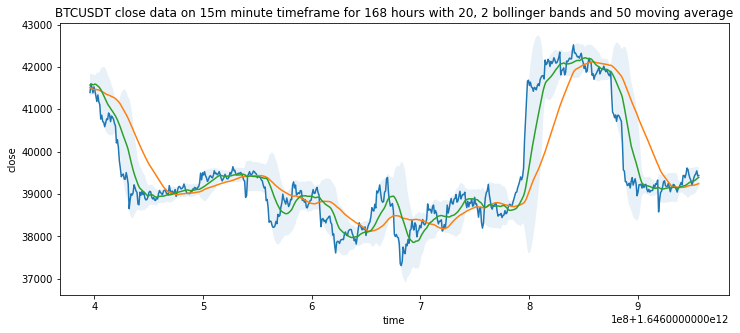

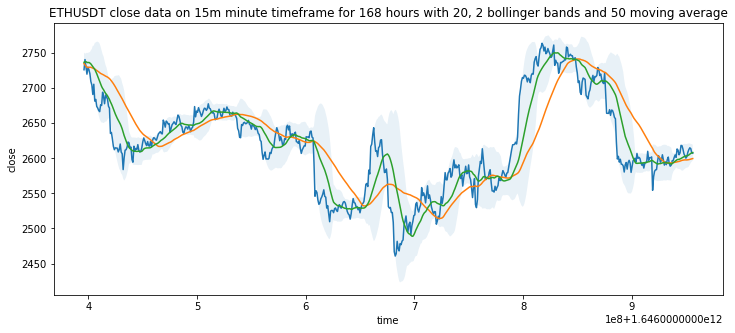

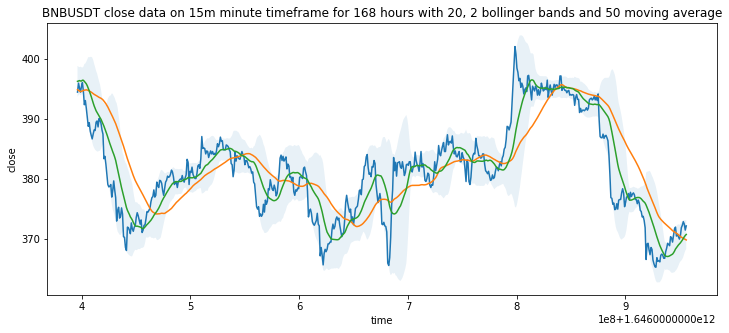

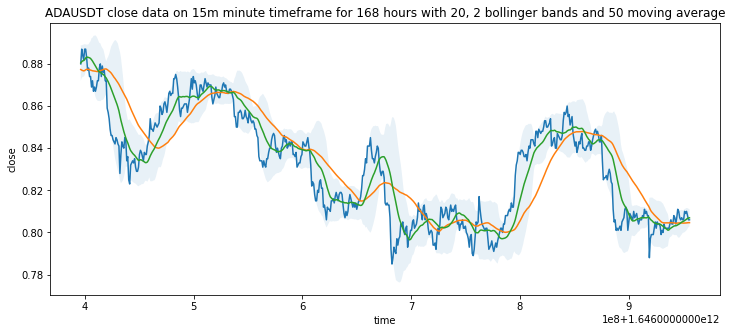

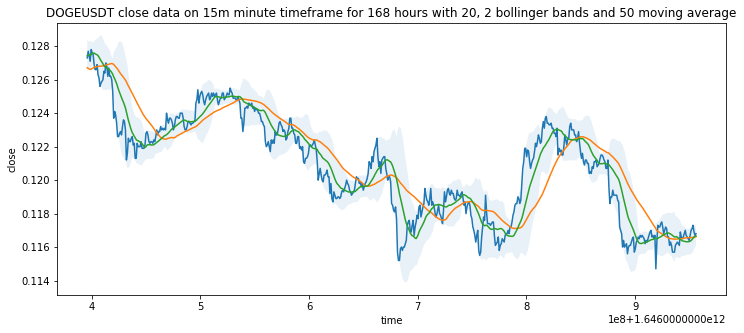

In [14]:
trader(0)